In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

C:\Users\bck00\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def plot_confusion_matrix(cm, 
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def plot_imp(model, X , num = 20):
    """
    This function prints and plots feature importances.
    """
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
#     plt.savefig('../Reports/figures/importances-01.png')
    plt.show()

In [4]:
def prep_data(lgbm=False):

    dem = pd.read_csv('../data/interim/demographics_train.csv')
    exp = pd.read_csv('../data/interim/exposure_train.csv')
    transfer = pd.read_csv('../data/interim/transfer_train.csv')
    
    # combine dfs together
    df = dem.merge(exp, how='left', on='EXCHANGE_ACCOUNT_ID').merge(
            transfer, how='left', left_on='EXCHANGE_ACCOUNT_ID', right_on='ACCOUNT_ID')
    
    drop_list = [x for x in df.columns if 'CURRENCY_sum' in x]
    if lgbm:
        # drop columns
        drop_list.extend(['BIRTH_YEAR', 'EXCHANGE_ACCOUNT_ID', 'ACCOUNT_ID', 'OCCUPATION', 'dummy', 'CREATED_AT', 'FIRST_VERIFIED_AT']) #lgb list
        cat_list = ['OCCUPATION_GROUP', 'STATE_CODE', 'COUNTRY_CODE'] 
        df[cat_list] = df[cat_list].astype('category') 
    else:
        drop_list.extend(['BIRTH_YEAR', 'EXCHANGE_ACCOUNT_ID', 'ACCOUNT_ID', 'OCCUPATION', 'CREATED_AT', 'FIRST_VERIFIED_AT', 
                          'OCCUPATION_GROUP', 'COUNTRY_CODE', 'STATE_CODE', 'dummy'])         
        df = df.fillna(df.mean())
        
    df.drop(drop_list, axis=1, inplace=True)
    
    # Creating the dependent variable class
    factor = pd.factorize(df['level'])
    df.level = factor[0]
    definitions = factor[1]
    
    # 80/20 split
    y = df.pop('level')
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
    
    return X_train, X_test, y_train, y_test
    

In [5]:
X_train, X_test, y_train, y_test = prep_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6592, 49)
(1649, 49)
(6592,)
(1649,)


# Modeling

In order for the model to have any value, it must beat the "baseline" accuracy which can be achieved by predicting the majority class for everything. 

In [6]:
baseline = y_train.value_counts().head(1).values[0]/ len(y_train)
baseline

0.515625

## Logistic Regression

Logistic regression is a simple linear model. It is often a good starting point.

In [7]:
X_train, X_test, y_train, y_test = prep_data()

In [8]:
clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [9]:
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=3))

             precision    recall  f1-score   support

          0      0.235     0.400     0.296        10
          1      0.382     0.116     0.178       499
          2      0.533     0.938     0.680       805
          3      0.426     0.080     0.135       286
          4      0.333     0.143     0.200        14
          5      0.000     0.000     0.000        21
          6      0.000     0.000     0.000         2
          7      0.000     0.000     0.000        12
          8      0.000     0.000     0.000         0

avg / total      0.454     0.511     0.413      1649



C:\Users\bck00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bck00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


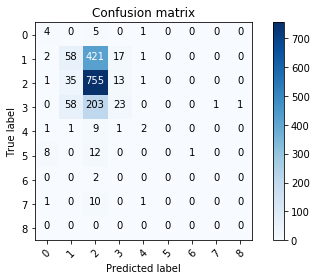

In [10]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8],
                      title='Confusion matrix')

In [11]:
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
metrics.accuracy_score(y_test, y_pred) > baseline

Accuracy: 0.5106124924196482


False

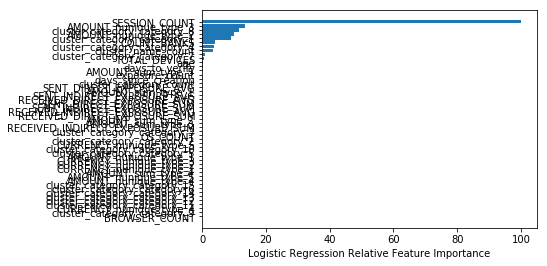

In [12]:
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx])
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx])
featax.set_xlabel('Logistic Regression Relative Feature Importance')
plt.show()

## Random Forest

In [13]:
X_train, X_test, y_train, y_test = prep_data()

In [14]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=3))

             precision    recall  f1-score   support

          0      0.375     0.900     0.529        10
          1      0.449     0.285     0.348       499
          2      0.591     0.856     0.699       805
          3      0.536     0.210     0.302       286
          4      0.421     0.571     0.485        14
          5      0.667     0.190     0.296        21
          6      0.000     0.000     0.000         2
          7      0.167     0.083     0.111        12

avg / total      0.533     0.554     0.511      1649



C:\Users\bck00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


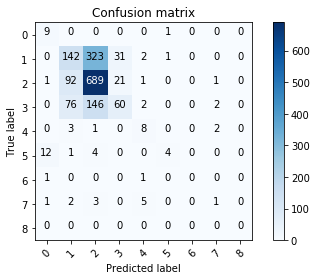

In [16]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8],
                      title='Confusion matrix')

In [17]:
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
metrics.accuracy_score(y_test, y_pred) > baseline

Accuracy: 0.553668890236507


True

Text(0.5,0,'Random Forest Feature Importance')

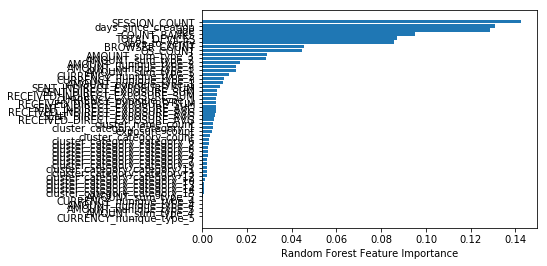

In [18]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Light GBM

Light GBM proves to have the strongest predictive performance. 

Benefits of light gbm include:
* Strong perfomance
* Robustness to outliers
* Ability to handle categorical variables without one-hot encoding
* Ability to handle missing data
* Speed

In [19]:
X_train, X_test, y_train, y_test = prep_data(lgbm=True)

In [20]:
# format data for lgbm
train_data = lgb.Dataset(X_train, label=y_train)

# model parameters (needs further tuning)
parameters = {
    'objective': 'multiclass',
    'num_class': 9,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'boost_from_average': True,
    'verbose': -1,
    'seed': 100
}

In [21]:
clf = lgb.train(parameters, train_data)

In [22]:
y_pred = clf.predict(X_test)
# get max probability for each prediction
y_pred = [np.argmax(line) for line in y_pred]
print(metrics.classification_report(y_test, y_pred, digits=3))

             precision    recall  f1-score   support

          0      0.471     0.800     0.593        10
          1      0.577     0.415     0.483       499
          2      0.685     0.911     0.782       805
          3      0.503     0.301     0.376       286
          4      0.471     0.571     0.516        14
          5      0.769     0.476     0.588        21
          6      0.000     0.000     0.000         2
          7      0.500     0.083     0.143        12

avg / total      0.616     0.639     0.609      1649



C:\Users\bck00\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


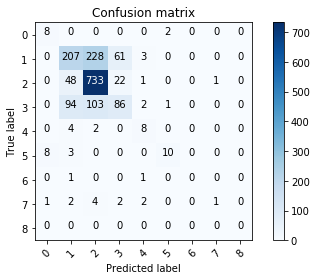

In [23]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8],
                      title='Confusion matrix')

In [24]:
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
metrics.accuracy_score(y_test, y_pred) > baseline

Accuracy: 0.6385688295936931


True

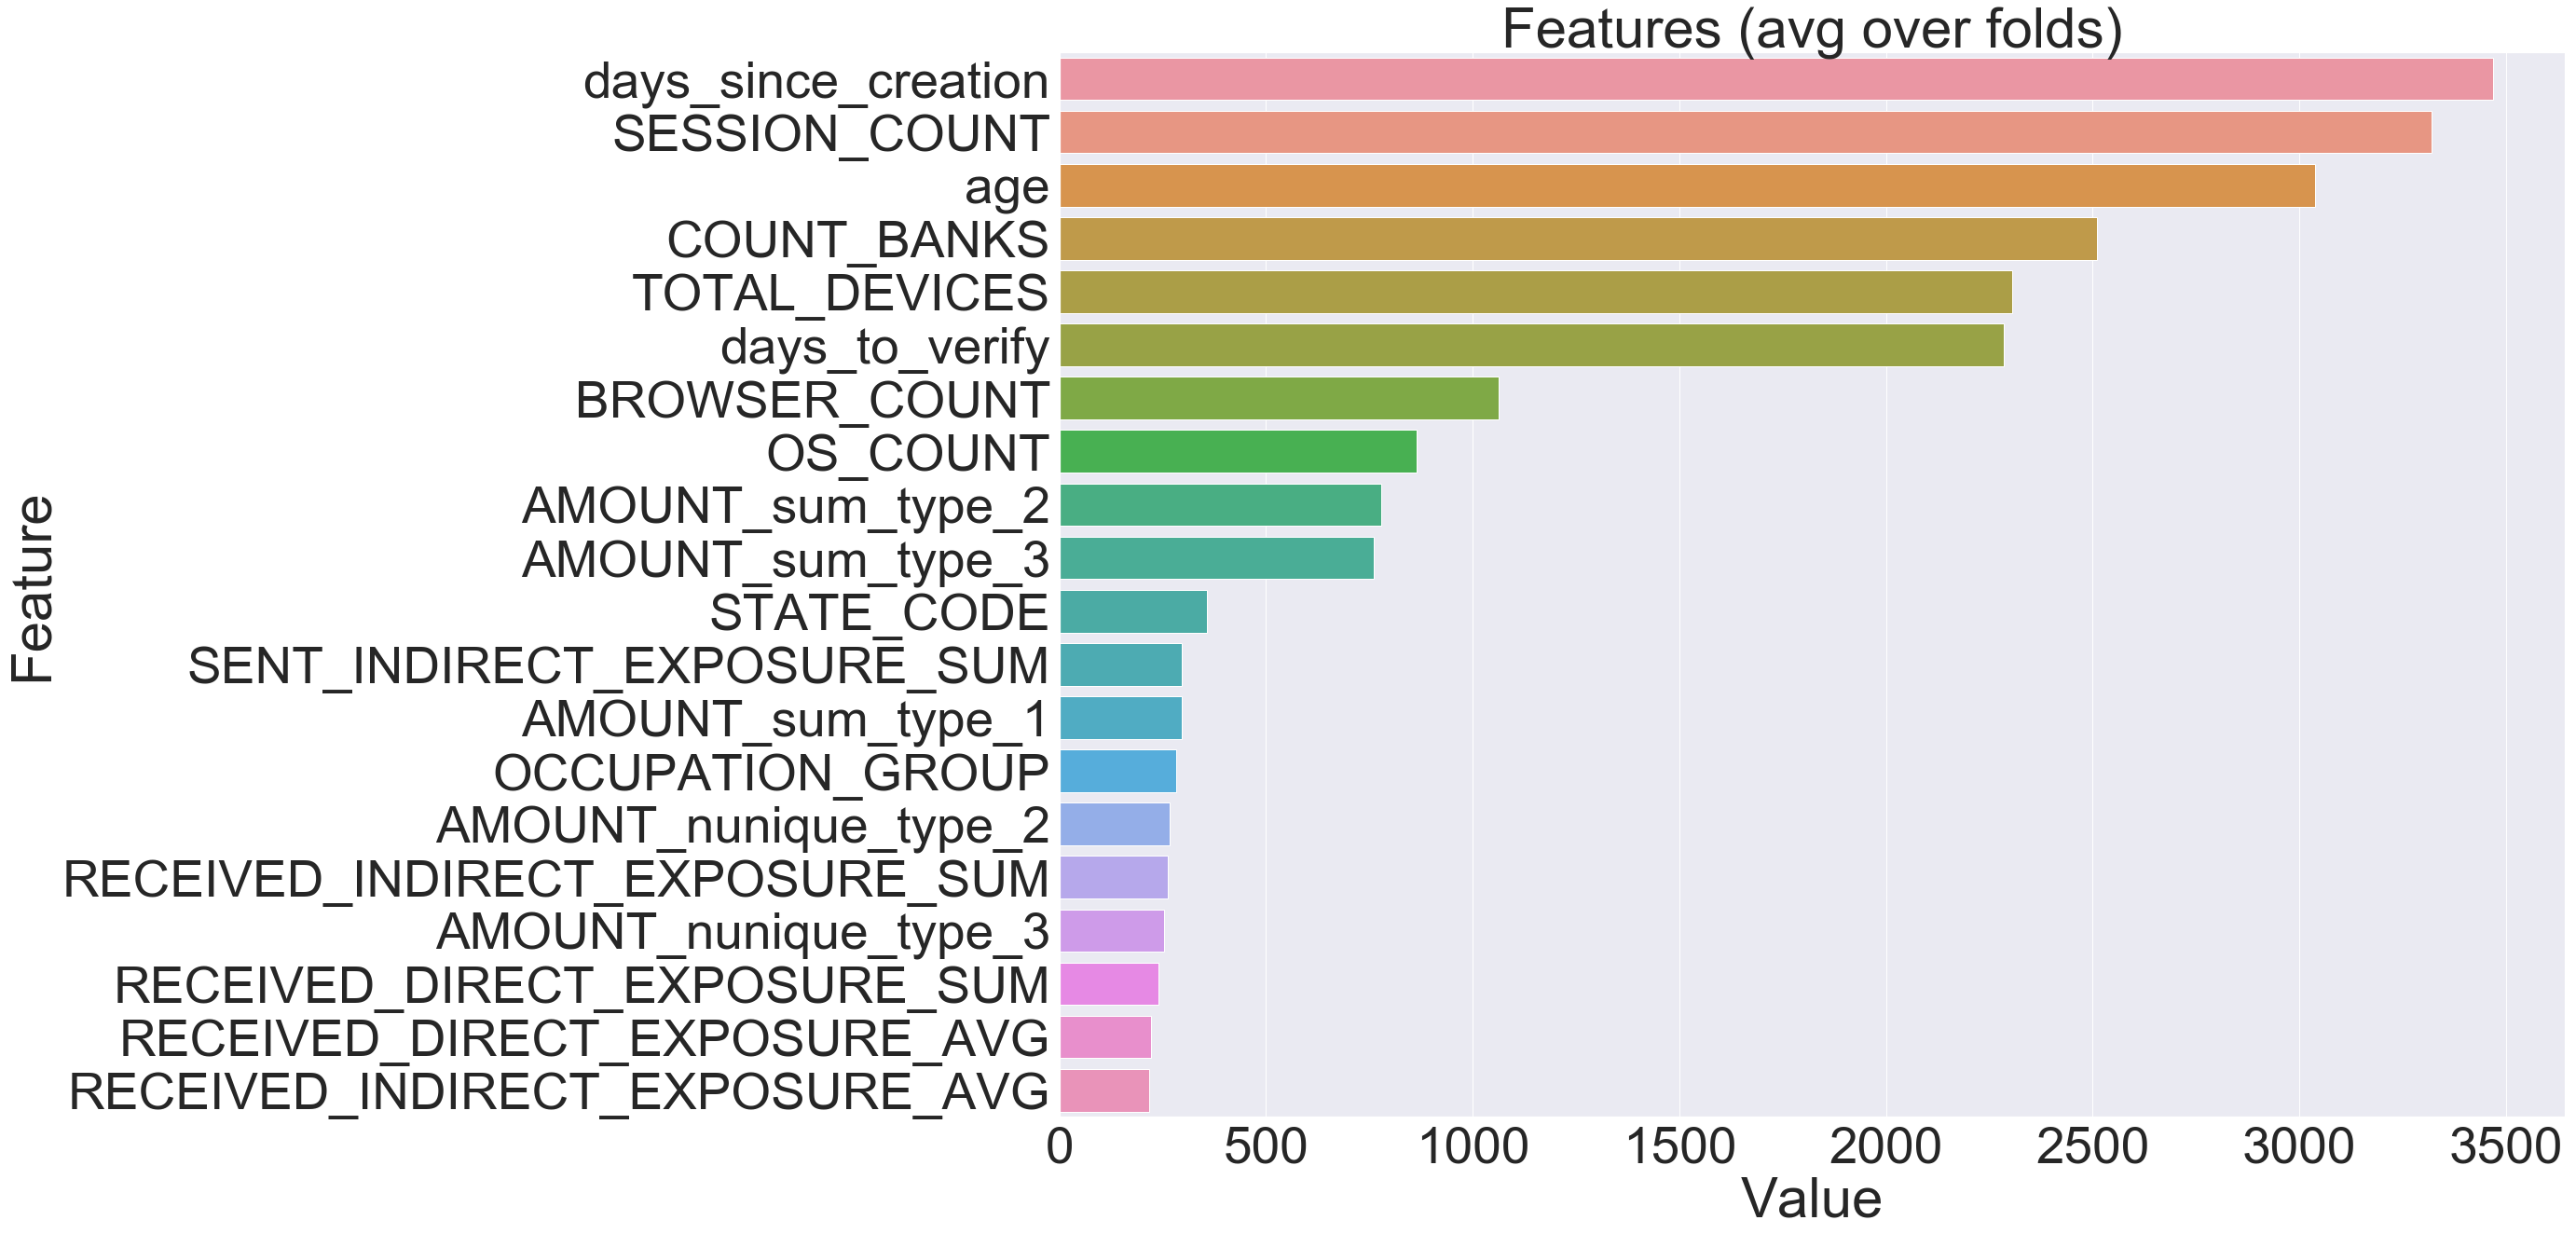

In [25]:
plot_imp(clf, X_train)